T. Tarantola, D. Kumaran, P. Dayan, & B. De Martino. (in press) Prior preferences beneficially influence social and non-social learning. <it>Nature Communications</it>.

#Data Extraction & Exclusion Tests: Social Experiment

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import curve_fit
import pylab as pl
import math
import seaborn as sns
import rpy2
import pystan
from pystan.external.pymc import plots
import pickle

% matplotlib inline
pd.options.display.max_rows = 999 # Set the maximum display to 999 rows so the entire dataframe is visible in the notebook
pd.options.display.max_columns = 999 # Same for columns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Data extraction (behavioral)

### Import Data
First, we import and concatenate the CSV files that PsychoPy generates for each experimental session. We put this in our data frame, called "data."

In [2]:
path =r'../data/social/raw_data' # This is the folder that all data CSV files are saved in
allFiles = glob.glob(path + '/*.csv')
data = pd.DataFrame()
list = []
for files in allFiles: # Read all CSV files in the "path" folder
    df = pd.read_csv(files, index_col=None, header=0)
    list.append(df)
data = pd.concat(list) # Concatenate all CSV files into one big data frame called "data"

# Replace dots in variable names with underscores, to make it easier for pandas to handle
data.rename(columns=lambda x: x.replace('.', '_'), inplace=True)

Then import the item familiarity/consumption data, which was entered by hand based on participants' pen-and-paper survey responses.

In [3]:
fam = pd.read_csv('../data/social/familiarity/familiarity_data_social.csv', index_col=0, header=None) # Import the CSV file
fam.index.name = 'participant' # Name the index of the data frame 'participant'
item_idx = fam.iloc[0] # Extract the name of each item to use as a column index later
rating_idx = fam.iloc[1] # Do the same for 'familiarity' and 'consumed' rating labels
fam.columns = [pd.Index(item_idx, name='item'),pd.Index(rating_idx, name='rating')] # Specify a hierarchical column index
fam = fam.iloc[2:] # Remove empty cells
fam = fam.stack('item') # Stack the data frame by item

### Calculate and create new variable columns in the data frame
We sort the data first by participant, then participant's experimental session (there might be more than one if the task crashed, etc), the image pair, the rest block it was presented during, and lastly the order of presentation within that block.

We then index the data frame by this new order.

In [4]:
data = data.sort(['participant','session','img_correct','block_loop_thisN','trial_loop_thisN']) # Sort the data
data.index = range(1,len(data)+1) # Re-do the index so it conforms to the sorted data

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


#### Bid and choice tasks
First, create two variables to explicitly indicate the participant's chosen and unchosen items in the binary choice task:

In [5]:
for x in range(1,len(data)+1):
    if data.loc[x,'key_resp_choice_keys']=='left':
        data.loc[x,'chosen']=data.loc[x,'choice_left']
        data.loc[x,'unchosen']=data.loc[x,'choice_right']
    elif data.loc[x,'key_resp_choice_keys']=='right':
        data.loc[x,'chosen']=data.loc[x,'choice_right']
        data.loc[x,'unchosen']=data.loc[x,'choice_left']

Next, calculate the z-scores for each bid, by participant, using the first and second bid task as separate populations.

In [6]:
bid_means = data.groupby(['participant']).bdm_bid1_response.mean() # Calculate each participant's mean bid
bid_sds = data.groupby(['participant']).bdm_bid1_response.std(ddof=0) # Calculate each participant's standard deviation of their bids

for x in range(1,len(data)+1): # For all rows...
    p = data.loc[x,'participant'] # Variable for the participant
    p_mean = bid_means[p] # Variable for that participant's mean bid
    p_sd = bid_sds[p] # That participant's bid SD
    bid = data.loc[x,'bdm_bid1_response'] # If that row is from the bid task, variable for that bid
    data.loc[x,'bdm_bid_response_zscore'] = (bid - p_mean)/p_sd # Add a new variable to the dataframe with that bid's z-score at the participant level

Import the item familiarity and consumption quesitonnaire data, including their within-participant z-scores, into the BDM task rows. 

The value labels are:

Familiarity: "How familiar are you with this item?"

    1 = Not at all
    2 = Somewhat
    3 = Very

Consumption: "How often have you consumed this item?"

    1 = Never
    2 = Sometimes
    3 = Frequently

In [7]:
for x in range(1,len(data)+1):
    if not pd.isnull(data.loc[x,'bdm_img']): # If the row is part of either BDM task
        p = data.loc[x,'participant']
        itm = data.loc[x,'bdm_img']
        data.loc[x,'familiarity'] = fam.ix[p,itm]['familiarity'] # Merge familiarity rating from familiarity data frame into main data frame for that participant and BDM item
        data.loc[x,'consumed'] = fam.ix[p,itm]['consumed'] # Do the same for consumption ratings
# Convert new variables into floats
data['familiarity'] = data['familiarity'].astype(float)
data['consumed'] = data['consumed'].astype(float)

In [8]:
# Calculate familiarity and consumed z-scores within participant
fam_means = data.groupby(['participant']).familiarity.mean()
fam_sds = data.groupby(['participant']).familiarity.std(ddof=0)
cons_means = data.groupby(['participant']).consumed.mean()
cons_sds = data.groupby(['participant']).consumed.std(ddof=0)

for x in range(1,len(data)+1):
    p = data.loc[x,'participant']
    p_mean_fam = fam_means[p]
    p_mean_cons = cons_means[p]
    p_sd_fam = fam_sds[p]
    p_sd_cons = cons_sds[p]
    fam = data.loc[x,'familiarity']
    cons = data.loc[x,'consumed']
    data.loc[x,'familiarity_zscore'] = (fam - p_mean_fam)/p_sd_fam
    data.loc[x,'consumed_zscore'] = (cons - p_mean_cons)/p_sd_cons

Then move the BDM bid and familiarity/consumption data, including their respective z-scores, into the binary choice rows:

In [9]:
for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'chosen']): # ... if there is a value in 'chosen' indicating that row is from the choice task
        bidmatch_all = data[data.loc[x,'chosen']==data.bdm_img] # find all BDM rows in the dataset that match that chosen item
        bidmatch_participant = bidmatch_all[data['participant']==data.loc[x,'participant']] # find the subset of bids from the same participant
        bidmatch_participant_notnull = bidmatch_participant[bidmatch_participant['bdm_bid1_response'].notnull()] # from those data, pick the BDM task
        bidmatch_participant_notnull_index = bidmatch_participant_notnull['bdm_bid1_response'].idxmax() # find the maximum to define as a single value index
        data.loc[x,'chosen_bid'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'bdm_bid1_response'] # define 'chosen_bid' on the choice row as the bid for that item
        data.loc[x,'chosen_bid_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'bdm_bid_response_zscore'] # define 'chosen_bid_zscore' on the choice row as the participant's z-score for the bid for that item from the same (first/last) part of the experiment
        data.loc[x,'chosen_familiarity'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'familiarity']
        data.loc[x,'chosen_familiarity_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'familiarity_zscore']
        data.loc[x,'chosen_consumed'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'consumed']
        data.loc[x,'chosen_consumed_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'consumed_zscore']

# Do the same for the unchosen items in each choice
for x in range(1,len(data)+1):
    if not pd.isnull(data.loc[x,'unchosen']):
        bidmatch_all = data[data.loc[x,'unchosen']==data.bdm_img]
        bidmatch_participant = bidmatch_all[data['participant']==data.loc[x,'participant']]
        bidmatch_participant_notnull = bidmatch_participant[bidmatch_participant['bdm_bid1_response'].notnull()]
        bidmatch_participant_notnull_index = bidmatch_participant_notnull['bdm_bid1_response'].idxmax()
        data.loc[x,'unchosen_bid'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'bdm_bid1_response']
        data.loc[x,'unchosen_bid_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'bdm_bid_response_zscore']
        data.loc[x,'unchosen_familiarity'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'familiarity']
        data.loc[x,'unchosen_familiarity_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'familiarity_zscore']
        data.loc[x,'unchosen_consumed'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'consumed']
        data.loc[x,'unchosen_consumed_zscore'] = bidmatch_participant_notnull.loc[bidmatch_participant_notnull_index,'consumed_zscore']
        

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


Generate a variable ('choice_dv') for the difference in bids between the chosen and unchosen items in each pair, and a variable ('choice_dv_zscore') for the difference between the bids' z-scores:

In [10]:
data['choice_dv'] = data['chosen_bid'] - data['unchosen_bid'] # Difference between the bid amounts
data['choice_dv_zscore'] = data['chosen_bid_zscore'] - data['unchosen_bid_zscore'] # Difference between the z-scores of the items' bids

Generate similar variables, but for the difference between the left and right choices:

In [11]:
data.loc[data['chosen']==data['choice_left'],'choice_dv_left_minus_right'] = data[data['chosen']==data['choice_left']]['choice_dv']
data.loc[data['chosen']==data['choice_right'],'choice_dv_left_minus_right'] = -data[data['chosen']==data['choice_right']]['choice_dv']

data.loc[data['chosen']==data['choice_left'],'choice_dv_zscore_left_minus_right'] = data[data['chosen']==data['choice_left']]['choice_dv_zscore']
data.loc[data['chosen']==data['choice_right'],'choice_dv_zscore_left_minus_right'] = -data[data['chosen']==data['choice_right']]['choice_dv_zscore']

Generate a dummy variable indicating whether the participant chose the item on the left:

In [12]:
data.loc[data['chosen']==data['choice_left'],'left_chosen'] = 1
data.loc[data['chosen']==data['choice_right'],'left_chosen'] = 0

Then calculate the z-scores for the choice confidence ratings, by participant, by task (first or second choice task).

In [13]:
conf_means = data.groupby(['participant']).confidence_rating1_response.mean() # Calculate each participant's mean confidence rating (from 1 to 6) during the choice task
conf_sds = data.groupby(['participant']).confidence_rating1_response.std(ddof=0) # Calculate each participant's standard deviation of their confidence rating in the choice task

for x in range(1,len(data)+1): # For all rows...
    p = data.loc[x,'participant'] # Variable for the participant
    p_mean = conf_means[p] # Variable for that participant's mean confidence in the choice task
    p_sd = conf_sds[p] # That participant's confidence SD for the choice task
    conf = data.loc[x,'confidence_rating1_response'] # If that row is from the choice task, variable for that confidence rating
    data.loc[x,'confidence_rating_response_zscore'] = (conf - p_mean)/p_sd # Add a new variable to the dataframe with that confidence rating's z-score at the participant level

Create a variable for the z-scores, by participant and by choice task, for the response times in each choice task.

In [14]:
choice_rt_means = data.groupby(['participant']).key_resp_choice_rt.mean()
choice_rt_sds = data.groupby(['participant']).key_resp_choice_rt.std(ddof=0)

for x in range(1,len(data)+1):
    p = data.loc[x,'participant']
    p_mean = choice_rt_means[p]
    p_sd = choice_rt_sds[p]
    rt = data.loc[x,'key_resp_choice_rt']
    data.loc[x,'key_resp_choice_rt_zscore'] = (rt - p_mean)/p_sd

####Learning task
Now we create a variable "pair_rep" to indicate how many times each image pair has been presented so far in the experiment.

In [15]:
data_infer = data[data['img_correct'].notnull()] # Subset of "data" where 'img_correct' has a value
data_infer = data_infer[data_infer['practice_loop_thisRepN']!=0] # Subset of "data_infer" that does NOT include practice trials
data_infer['pair_rep'] = range(1,31) * (len(data_infer)/30) # Note: Change range and denominator if number of item presentations differs from 30
data['pair_rep'] = data_infer['pair_rep'] # Populate main data frame with this new variable

Next, we generate a variable "response_correct" to indicate whether the subject responded correctly on each given trial.

In [16]:
# Create series variables from the sorted dataframe for easy handling in the loop below
arr_img_correct = data['img_correct']
arr_img_left = data['img_left']
arr_img_right = data['img_right']
arr_infer_resp = data['infer_resp_keys']

# Generate a variable indicating whether the response was correct on each given trial
for x in range(1,len(data)+1): 
    if arr_img_correct[x]==arr_img_left[x] and arr_infer_resp[x]=='left':
        data.at[x,'response_correct'] = 1
    elif arr_img_correct[x]==arr_img_left[x] and arr_infer_resp[x]=='right':
        data.at[x,'response_correct'] = 0
    elif arr_img_correct[x]==arr_img_right[x] and arr_infer_resp[x]=='right':
        data.at[x,'response_correct'] = 1
    elif arr_img_correct[x]==arr_img_right[x] and arr_infer_resp[x]=='left':
        data.at[x,'response_correct'] = 0

Then, create a variable "feedback_correct" to indicate whether the box appeared around the correct (=1) or incorrect (=0) item after the response was collected on that trial.

In [17]:
for x in range(1,len(data)+1):
    if pd.isnull(data.loc[x,'practice_loop_thisRepN']): # If the row is NOT part of the learning practice block
        if data.loc[x,'set_feedback_feedback_img']==data.loc[x,'img_correct']:
            data.at[x,'feedback_correct'] = 1
        elif data.loc[x,'set_feedback_feedback_img']==data.loc[x,'img_wrong']:
            data.at[x,'feedback_correct'] = 0

Then, create a variable "reward" to indicate whether the outcome yellow box on a particular trial matched the participant's response on that trial. So for example, if the participant chose the correct item, and then the yellow box was displayed around the correct item, that reward would be coded as 1 for that trial. Similarly, if the participant chose the wrong item, but the yellow box then also appeared around the wrong item, the reward would also be coded as 1.

If, however, the participant chose a different item from the one the yellow box then displays around (e.g. the participant chose the correct item but the box displays around the wrong item, or vice versa), the reward is coded as 0 for that trial.

In [18]:
for x in range(1,len(data)+1):
    if pd.isnull(data.loc[x,'practice_loop_thisRepN']): # If the row is not part of the inference practice block
        if data.loc[x,'response_correct']==data.loc[x,'feedback_correct']:
            data.at[x,'reward'] = 1
        elif data.loc[x,'response_correct']!=data.loc[x,'feedback_correct']:
            data.at[x,'reward'] = 0

Then calculate the number of correct feedback boxes (where the yellow box appeared around the correct item) seen so far for that pair.

In [19]:
for x in range(1,len(data)+1):
    if not pd.isnull(data.loc[x,'img_correct']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']): # If in the main inference task (not the practice block)
        part = data.loc[x,'participant']
        itm = data.loc[x,'img_correct']
        pair = data.loc[x,'pair_rep']
        data_part = data[data['participant']==part]
        data_part_itm = data_part[data_part['img_correct']==itm]
        feedbck_corr_sum = data_part_itm[data_part_itm['pair_rep']<pair].feedback_correct.sum() # Sum of the correct feedback (yellow boxes around the correct answer) of trials in that item for that participant with lower pair_rep number than the current row
        data.loc[x,'feedback_correct_sum'] = feedbck_corr_sum 
        data.loc[x,'feedback_wrong_sum'] = (pair - 1) - feedbck_corr_sum # Subtract to get the number of wrong feedback up until that point (yellow boxes around the wrong answer)

Create a variable for the difference between the number of correct and wrong feedback boxes displayed so far.

In [20]:
data['feedback_correct_sum_diff'] = data['feedback_correct_sum'] - data['feedback_wrong_sum']

Calculate the trial number, and the number of trials (presentation of other item pairs) between the current and last presentation of that item pair (interference)

In [21]:
# Calculate the trial number, for all three blocks combined
for x in range(1,len(data)+1):
    if data.loc[x,'block_loop_thisN']==0:
        data.loc[x,'learning_trial'] = data.loc[x,'trial_loop_thisN']
    elif data.loc[x,'block_loop_thisN']==1:
        data.loc[x,'learning_trial'] = data.loc[x,'trial_loop_thisN'] + 200
    elif data.loc[x,'block_loop_thisN']==2:
        data.loc[x,'learning_trial'] = data.loc[x,'trial_loop_thisN'] + 400

for x in range(1,len(data)+1):
    if data.loc[x,'pair_rep'] > 1:
        data.loc[x,'interference'] = data.loc[x,'learning_trial'] - data.loc[x-1,'learning_trial'] - 1

Calculate the z-scores, by participant, for their reaction times in the inference task.

In [22]:
rt_means = data.groupby(['participant']).infer_resp_rt.mean()
rt_sds = data.groupby(['participant']).infer_resp_rt.std(ddof=0)

for x in range(1,len(data)+1):
    p = data.loc[x,'participant']
    p_mean = rt_means[p]
    p_sd = rt_sds[p]
    rt = data.loc[x,'infer_resp_rt']
    data.loc[x,'infer_resp_rt_zscore'] = (rt - p_mean)/p_sd

Next, move the participant's item bids into new variables aligned with the inference task. These will be signed to indicate congruency with the choice being inferred; the participant's bid for the incorrect item is subtracted from the bid for the correct item to create a correct_bid_dv variable. Strongly negative values for this variable, therefore, indicate a strong preference in the opposite direction as the choice being inferred. Strongly positive values indicate strong congruency with the choice being inferred.

In [23]:
for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'img_correct']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']): # ... if there is a value in 'img_correct' indicating that row is from the inference task, and it is not in the practice block
        bid_inf_all = data[data.loc[x,'img_correct']==data.bdm_img] # find all BDM rows in the dataset that match that correct item
        bid_inf_participant = bid_inf_all[data['participant']==data.loc[x,'participant']] # find the subset of bids from the same participant
        bid_inf_participant_notnull = bid_inf_participant[bid_inf_participant['bdm_bid1_response'].notnull()] # from those data, pick the BDM task
        bid_inf_participant_notnull_index = bid_inf_participant_notnull['bdm_bid1_response'].idxmax() # find the maximum to define as a single value index
        data.loc[x,'correct_bid'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'bdm_bid1_response'] # define 'correct_bid' on the inference row as the bid for that item
        data.loc[x,'correct_bid_zscore'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'bdm_bid_response_zscore'] # and add a variable for that participant's zscore of the bid for the correct item
        data.loc[x,'correct_familiarity'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'familiarity'] # and add a variable for that participant's familiarity with that item
        data.loc[x,'correct_familiarity_zscore'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'familiarity_zscore'] # and add a variable for that participant's familiarity z-score
        data.loc[x,'correct_consumed'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'consumed'] # and add a variable for that participant's past consumption of that item
        data.loc[x,'correct_consumed_zscore'] = bid_inf_participant_notnull.loc[bid_inf_participant_notnull_index,'consumed_zscore'] # and add a variable for that participant's item consumption zscore

# Do the same for the incorrect items in each inference trial
for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'img_wrong']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']):
        bid_infwr_all = data[data.loc[x,'img_wrong']==data.bdm_img] 
        bid_infwr_participant = bid_infwr_all[data['participant']==data.loc[x,'participant']] 
        bid_infwr_participant_notnull = bid_infwr_participant[bid_infwr_participant['bdm_bid1_response'].notnull()] 
        bid_infwr_participant_notnull_index = bid_infwr_participant_notnull['bdm_bid1_response'].idxmax() 
        data.loc[x,'wrong_bid'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'bdm_bid1_response']
        data.loc[x,'wrong_bid_zscore'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'bdm_bid_response_zscore']
        data.loc[x,'wrong_familiarity'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'familiarity'] # and add a variable for that participant's familiarity with that item
        data.loc[x,'wrong_familiarity_zscore'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'familiarity_zscore'] # and add a variable for that participant's familiarity z-score
        data.loc[x,'wrong_consumed'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'consumed'] # and add a variable for that participant's past consumption of that item
        data.loc[x,'wrong_consumed_zscore'] = bid_infwr_participant_notnull.loc[bid_infwr_participant_notnull_index,'consumed_zscore'] # and add a variable for that participant's item consumption zscore

# Define congruency variables for each BDM task:
data['inf_bid_dv']=data['correct_bid'] - data['wrong_bid'] # Difference in absolute bid amounts from the bid task
data['inf_bid_dv_zscore']=data['correct_bid_zscore'] - data['wrong_bid_zscore'] # Difference in bid amount z-scores from the bid task

# Define familiarity and consumption rating z-score differences for each item
data['familiarity_dv_zscore']=data['correct_familiarity_zscore'] - data['wrong_familiarity_zscore']
data['consumed_dv_zscore']=data['correct_consumed_zscore'] - data['wrong_consumed_zscore']

Was the correct answer in the learning task pair chosen by the participant in the choice task? Create variables that indicate the number of times it was chosen (each pair was presented in the choice task twice; 0=never chosen; 1=chosen once but not chosen the second time; 2=chosen twice).

In [24]:
chosen_data = pd.DataFrame(data.groupby('participant').chosen.value_counts()) # The number of times each item was chosen in the choice task, grouped by participant
chosen_data.columns = ['number'] # Give the column with this number a name
chosen_data.index.names = ['participant','item'] # Name the hierarchical index of this dataframe
for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'img_correct']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']): # If the row is part of the inference task, and not part of the practice block...
        part = data.loc[x,'participant'] # The participant
        itm = data.loc[x,'img_correct'] # The chosen item (correct answer) they're trying to learn
        if not chosen_data.xs((part,itm), level=('participant','item')).values: # If the correct answer was not chosen by the participant at least once during the first choice task
            data.loc[x,'choice_correct_congruence'] = 0 # ...the choice congruence score is 0
        else: # Otherwise, it's the number of times that item was chosen in the choice task (either 1 or 2)
            data.loc[x,'choice_correct_congruence'] = chosen_data.number.xs((part,itm), level=('participant','item')).values

Move the choice confidence ratings, their within-participant (grouped by first and second choice task) z-scores, and response times and their z-scores, into the inference task rows. Since each participant indicated their choice in each item pair twice (flipping side of the screen once), there are 4 variables stored (each of these confidence ratings and their z-scores).

In [25]:
for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'img_correct']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']): # ... if there is a value in 'img_correct' indicating that row is from the inference task, and it is not in the practice block
    # CONFIDENCE 
    # Get the confidence ratings from the choice task, from the trials where the correct item appears on the LEFT   
        conf_left_inf_all = data[data.loc[x,'img_correct']==data.choice_left] # find all choice rows in the dataset that match that correct item, where the correct item was shown on the LEFT
        conf_left_inf_participant = conf_left_inf_all[data['participant']==data.loc[x,'participant']] # find the subset of confidence ratings from the same participant
        conf_left_inf_participant_notnull = conf_left_inf_participant[conf_left_inf_participant['confidence_rating1_response'].notnull()] # from those data, pick the choice task
        conf_left_inf_participant_notnull_index = conf_left_inf_participant_notnull['confidence_rating1_response'].idxmax() # find the maximum to define as a single value index
        data.loc[x,'conf_correct_on_left'] = conf_left_inf_participant_notnull.loc[conf_left_inf_participant_notnull_index,'confidence_rating1_response'] # define 'conf_correct_on_left' on the inference row as the confidence rating for that item where the correct item was displayed on the LEFT
        data.loc[x,'conf_correct_on_left_zscore'] = conf_left_inf_participant_notnull.loc[conf_left_inf_participant_notnull_index,'confidence_rating_response_zscore'] # and add a variable for that participant's zscore of the confidence rating for the correct item from the choice task
    # Get the confidence ratings from the choice task, where the correct item appears on the RIGHT
        conf_right_inf_all = data[data.loc[x,'img_correct']==data.choice_right] # find all choice rows in the dataset that match that correct item, where the correct item was shown on the RIGHT
        conf_right_inf_participant = conf_right_inf_all[data['participant']==data.loc[x,'participant']] # find the subset of confidence ratings from the same participant
        conf_right_inf_participant_notnull = conf_right_inf_participant[conf_right_inf_participant['confidence_rating1_response'].notnull()] # from those data, pick the choice task
        conf_right_inf_participant_notnull_index = conf_right_inf_participant_notnull['confidence_rating1_response'].idxmax() # find the maximum to define as a single value index
        data.loc[x,'conf_correct_on_right'] = conf_right_inf_participant_notnull.loc[conf_right_inf_participant_notnull_index,'confidence_rating1_response'] # define 'conf1_correct_on_right' on the inference row as the confidence rating for that item where the correct item was displayed on the RIGHT
        data.loc[x,'conf_correct_on_right_zscore'] = conf_right_inf_participant_notnull.loc[conf_right_inf_participant_notnull_index,'confidence_rating_response_zscore'] # and add a variable for that participant's zscore of the confidence rating for the correct item from the choice task
   

    # CHOICE RESPONSE TIMES
    # Get the choice response tims from the choice task, from the trials where the correct item appears on the LEFT   
        chc_left_inf_all = data[data.loc[x,'img_correct']==data.choice_left] 
        chc_left_inf_participant = chc_left_inf_all[data['participant']==data.loc[x,'participant']]
        chc_left_inf_participant_notnull = chc_left_inf_participant[chc_left_inf_participant['key_resp_choice_rt'].notnull()] 
        chc_left_inf_participant_notnull_index = chc_left_inf_participant_notnull['key_resp_choice_rt'].idxmax()
        data.loc[x,'chc_correct_on_left_rt'] = chc_left_inf_participant_notnull.loc[chc_left_inf_participant_notnull_index,'key_resp_choice_rt'] 
        data.loc[x,'chc_correct_on_left_rt_zscore'] = chc_left_inf_participant_notnull.loc[chc_left_inf_participant_notnull_index,'key_resp_choice_rt_zscore'] 
    # Get the choice response tims from the choice task, from the trials where the correct item appears on the RIGHT   
        chc_right_inf_all = data[data.loc[x,'img_correct']==data.choice_right] 
        chc_right_inf_participant = chc_right_inf_all[data['participant']==data.loc[x,'participant']]
        chc_right_inf_participant_notnull = chc_right_inf_participant[chc_right_inf_participant['key_resp_choice_rt'].notnull()] 
        chc_right_inf_participant_notnull_index = chc_right_inf_participant_notnull['key_resp_choice_rt'].idxmax()
        data.loc[x,'chc_correct_on_right_rt'] = chc_right_inf_participant_notnull.loc[chc_right_inf_participant_notnull_index,'key_resp_choice_rt'] 
        data.loc[x,'chc_correct_on_right_rt_zscore'] = chc_right_inf_participant_notnull.loc[chc_right_inf_participant_notnull_index,'key_resp_choice_rt_zscore'] 

Calculate the mean confidence and response time z-scores of the two presentations in the choice task:

In [26]:
data['conf_mean_zscore'] = (data['conf_correct_on_left_zscore'] + data['conf_correct_on_right_zscore'])/2
data['chc_rt_mean_zscore'] = (data['chc_correct_on_left_rt_zscore'] + data['chc_correct_on_right_rt_zscore'])/2

Create a variable "choice_presentation" to indicate, for the choice trials, whether it is the first (1) or second (2) presentation of that pair.

In [27]:
data['pairID'] = np.nan # Set up a temporary variable to identify each unique item pair in the choice task

for x in data['participant'].unique(): # For each participant...
    
    right_choices=[] # Variable to keep track of choice stimuli displayed on the right side of the screen
    pair_counter = 1 # Counter to keep track of how many time that item pair has been displayed so far in the choice task

    for trial in data.loc[((data['choice_left'].notnull()) & (data['participant']==x)), 'binary_thisN']: # Within the choice task for that participant, for each trial...
        if data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'choice_left'].any() in right_choices: # If the left choice has already been displayed on the right,
            data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'pairID'] = data.loc[((data['choice_right']==data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'choice_left'].get_values()[0]) & (data['participant']==x)), 'pairID'].get_values()[0] # then assign it the same pairID
            data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'choice_presentation'] = 2 # And set the 'choice_presentation' number to 2
        else:
            data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'pairID'] = pair_counter # Otherwise, assign the next available pairID
            data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'choice_presentation'] = 1 # Set the choice presentation number to 1
            pair_counter += 1 # Increase the pairID counter
            right_choices.append(data.loc[((data['binary_thisN']==trial) & (data['participant']==x)), 'choice_right'].get_values()[0]) # And add the choice on the right to our list

#data = data.drop('pairID',1) # When finished, drop the pair ID column from the data

Create two more dummy variables indicating whether the participant chose the left choice on the first presentation of that pair, and the right choice on the second presentation of that pair.

In [28]:
data.loc[((data['left_chosen']==1) & (data['choice_presentation']==1)),'left_chosen_firstpres'] = 1
data.loc[((data['left_chosen']==0) & (data['choice_presentation']==1)),'left_chosen_firstpres'] = 0
data.loc[((data['left_chosen']==1) & (data['choice_presentation']==2)),'right_chosen_secondpres'] = 0
data.loc[((data['left_chosen']==0) & (data['choice_presentation']==2)),'right_chosen_secondpres'] = 1

In [29]:
for x in data['participant'].unique(): # For each participant...
    for y in data.loc[((data['choice_left'].notnull()) & (data['participant']==x)), 'pairID']:
        data.loc[((data['pairID']==y) & (data['participant']==x) & (data['choice_presentation']==2)), 'left_chosen_firstpres'] = data.loc[((data['pairID']==y) & (data['participant']==x) & (data['choice_presentation']==1)), 'left_chosen_firstpres'].get_values()[0]
        data.loc[((data['pairID']==y) & (data['participant']==x) & (data['choice_presentation']==1)), 'right_chosen_secondpres'] = data.loc[((data['pairID']==y) & (data['participant']==x) & (data['choice_presentation']==2)), 'right_chosen_secondpres'].get_values()[0]

Create a dummy variable to indicate whether the correct image in the learning task was displayed on the left side of the screen.

In [30]:
data.loc[(data['img_correct']==data['img_left']), 'correct_on_left'] = 1
data.loc[(data['img_correct']==data['img_right']), 'correct_on_left'] = 0

Finally, create a dummy variable to indicate whether the participant responded "left".

In [31]:
data.loc[data['infer_resp_keys']=='left', 'infer_response_left'] = 1
data.loc[data['infer_resp_keys']=='right', 'infer_response_left'] = 0

Save the dataframe as CSV and PKL files

In [32]:
data.to_csv(path_or_buf=r'../data/social/data_processed_social.csv')
data.to_pickle(r'../data/social/data_processed_social.pkl')

##A priori participant exclusion

We set the following a priori exclusion criteria for participants (see 'analysis_code/exclusion_criteria.docx'):

Participants’ data will be excluded if:

1)	They indicate at any point before, during, or after testing that they do not meet the following eligibility criteria:
a.	Are at least 18 years old,
b.	Are proficient in English, and
c.	Do not suffer from any psychiatric or neurological disorder.

2)	They end their participation before the conclusion of the study, including by asking to leave before the post-experiment wait period has ended, or by consuming food or non-water drink that was not purchased during the auction.

3)	They indicate that they did not comply with the requirement to drink only water and refrain from eating for 3 hours before attending the session.

4)	Their responses in the choice task are inconsistent to the extent that a response on the first presentation of an item pair does not significantly and positively predict their response during the second presentation of that item pair. This will be tested using a logistic regression analysis predicting the response during the second presentation of the item pairs, using the response during the first presentation of that pair as the independent variable. The regression coefficient weighting this variable must be greater than zero with a probability of more than 95%.

5)	They use a very narrow range of the confidence scale. Specifically, if one standard deviation of a subject’s scale use represents less than 16% of the total range of the scale. (See De Martino, Fleming, Garrett, and Dolan, 2012, Nature Neuroscience.)

6)	If their bids or confidence ratings can be significantly predicted by the randomly jittered starting point of the scale. This will be determined by two linear regression analyses predicting the confidence and bid responses separately, using the starting point as the independent variable.  A participant will be excluded if the coefficient weighting the starting point is significantly different from zero with a probability of more than 95% in either of these analyses. 

7)	If their bids do not predict their choices. Specifically, participants will be excluded if the inverse temperature parameter for a participant is five or more times larger than the mean for the entire group. (See De Martino, Fleming, Garrett, and Dolan, 2012, Nature Neuroscience.)

8)	If their mean performance on the learning task is not significantly above chance. 


###Criteria 1-3: Failure to abide by study requirements
No participants met any of these criteria. (See participant log at 'recruitment/participant_log.xlsx')

###Criterion 4: Choice consistency

In [33]:
def check_choice_consistency(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['chosen'].notnull()]
    data_subset['intercept'] = 1.0
    logit = sm.Logit(data_subset['right_chosen_secondpres'], data_subset[['left_chosen_firstpres','intercept']])
    result = logit.fit()
    print subj, result.summary()

def check_choice_consistency_linear(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['chosen'].notnull()]
    data_subset['intercept'] = 1.0
    x = np.array(data_subset['left_chosen_firstpres'])
    y = np.array(data_subset['right_chosen_secondpres'])
    slope, intercept, r_value, p_value, slope_std_error = ss.linregress(x, y)
    return subj, slope, p_value

for x in data['participant'].unique():
    if check_choice_consistency_linear(x)[1]<0 or check_choice_consistency_linear(x)[2]>0.05:
        print 'Exclude ',x

For all participants, the first choice significantly predicts the second choice with greater than 95% probability. Because many participants showed perfect consistency, logistic regressions were impossible to estimate, so linear regressions were substituted. 

No participants would be excluded under this criterion.

In [34]:
for x in data['participant'].unique():
    print 'Number of inconsistent choices for participant ', x, len(data.loc[data['participant']==x, 'chosen'].unique())-21
#data.groupby(['participant']).chosen.value_counts()
len(data['chosen'].unique())

Number of inconsistent choices for participant  E1 0
Number of inconsistent choices for participant  E10 0
Number of inconsistent choices for participant  E11 0
Number of inconsistent choices for participant  E12 0
Number of inconsistent choices for participant  E13 2
Number of inconsistent choices for participant  E14 0
Number of inconsistent choices for participant  E15 0
Number of inconsistent choices for participant  E16 4
Number of inconsistent choices for participant  E17 0
Number of inconsistent choices for participant  E18 1
Number of inconsistent choices for participant  E19 0
Number of inconsistent choices for participant  E2 1
Number of inconsistent choices for participant  E20 1
Number of inconsistent choices for participant  E21 0
Number of inconsistent choices for participant  E22 0
Number of inconsistent choices for participant  E23 0
Number of inconsistent choices for participant  E24 0
Number of inconsistent choices for participant  E25 0
Number of inconsistent choices

41

###Criterion 5: Use of confidence scale

We now check to see whether each participant used an appropriate range of the scale (pre-determined to be one standard deviation of 16%, or 0.8 scale units, after De Martino, Fleming, Garrett, and Dolan, 2012, Nature Neuroscience).

In [35]:
data.groupby(['participant']).confidence_rating1_response.std(ddof=0) #< 0.8

participant
E1     1.036433
E10    1.447444
E11    0.793710
E12    1.218852
E13    0.991350
E14    1.002868
E15    0.659351
E16    1.080483
E17    1.260516
E18    0.715258
E19    0.593922
E2     1.110304
E20    1.191123
E21    1.208139
E22    1.460274
E23    0.749062
E24    1.285085
E25    0.553963
E26    1.217128
E27    1.815625
E28    1.214650
E29    1.562490
E3     1.242676
E30    0.882822
E31    0.978455
E32    1.223599
E33    1.092428
E4     1.545510
E5     1.066243
E6     1.451715
E7     0.826680
E8     1.885444
E9     1.339475
Name: confidence_rating1_response, dtype: float64

Based on this criterion, we would exclude participants E11, E15, E18, E19, E23, and E25.

###Criterion 6: Bids or confidence ratings predicted by jittered starting points

Next we run regression analyses to determine whether a participant's bid or confidence responses were significantly predicted by the jittered starting point of the scale marker.

In [36]:
def check_jitter_effect_bids(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['bdm_bid1_response'].notnull()]
    x = np.array(data_subset['bdm_marker_start'])
    y = np.array(data_subset['bdm_bid1_response'])
    slope, intercept, r_value, p_value, slope_std_error = ss.linregress(x, y)
    #plt.scatter(x, y)
    #plt.show()
    return subj, p_value, r_value, slope

for x in data['participant'].unique():
    if check_jitter_effect_bids(x)[1] <0.05:
        print check_jitter_effect_bids(x)[0], check_jitter_effect_bids(x)[1]

No participant meets this criterion for the bid scale.

In [37]:
def check_jitter_effect_confidence(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['confidence_rating1_response'].notnull()]
    x = np.array(data_subset['confidence_marker_start'])
    y = np.array(data_subset['confidence_rating1_response'])
    slope, intercept, r_value, p_value, slope_std_error = ss.linregress(x, y)
    #plt.scatter(x, y)
    #plt.show()
    return subj, p_value, r_value, slope

def check_jitter_effect_confidence_plot(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['confidence_rating1_response'].notnull()]
    x = np.array(data_subset['confidence_marker_start'])
    y = np.array(data_subset['confidence_rating1_response'])
    slope, intercept, r_value, p_value, slope_std_error = ss.linregress(x, y)
    plt.scatter(x, y)
    plt.show()

for x in data['participant'].unique():
    if check_jitter_effect_confidence(x)[1] <0.05:
        print 'Participant',check_jitter_effect_confidence(x)[0], ', p=',check_jitter_effect_confidence(x)[1], ', r=',check_jitter_effect_confidence(x)[2], ', slope=',check_jitter_effect_confidence(x)[2]**2



Participant E18 , p= 0.0044210737297 , r= 0.440744269817 , slope= 0.194255511376
Participant E25 , p= 0.00122567551752 , r= 0.493101277099 , slope= 0.243148869476
Participant E33 , p= 0.022980736332 , r= -0.358824737619 , slope= 0.128755192328
Participant E5 , p= 0.00685621220024 , r= -0.420793513205 , slope= 0.177067180755
Participant E6 , p= 0.00258766973022 , r= -0.463604614747 , slope= 0.214929238815


Participants E5, E6, E18, E25, and E33 would be excluded under this criterion for the confidence scale.

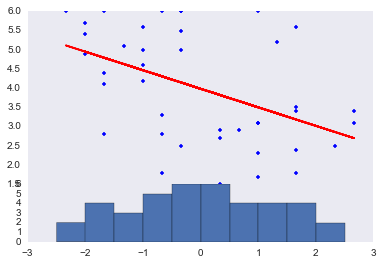

In [38]:
def check_jitter_effect_confidence_plot_resid(subj):
    #Data
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['confidence_rating1_response'].notnull()]
    x = np.array(data_subset['confidence_marker_start'])
    y = np.array(data_subset['confidence_rating1_response'])

    #Model
    Fofx = lambda x,a,b: a*x+b
    #Best fit parameters
    p, cov = curve_fit(Fofx,x,y)

    #PLOT
    fig1 = plt.figure(1)
    #Plot Data-model
    frame1=fig1.add_axes((.1,.3,.8,.6))
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    plt.plot(x,y,'.b') #Noisy data
    plt.plot(x,Fofx(x,*p),'-r') #Best fit model
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    plt.grid()

    #Residual plot
    difference = Fofx(x,*p) - y
    frame2=fig1.add_axes((.1,.1,.8,.2))        
    plt.hist(difference)
    plt.grid()
check_jitter_effect_confidence_plot_resid('E6')

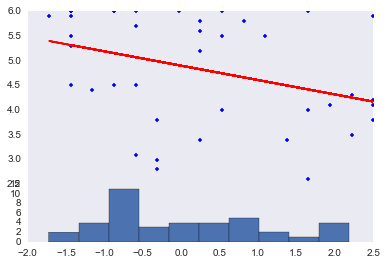

In [39]:
check_jitter_effect_confidence_plot_resid('E33')

###Criterion 7: Bids do not predict choices

In [40]:
def check_bid_predicting_choice(subj):
    data_subset = data[data['participant']==subj]
    data_subset = data_subset[data_subset['chosen'].notnull()]
    data_subset['intercept'] = 1.0
    logit = sm.Logit(data_subset['left_chosen'], data_subset[['choice_dv_left_minus_right','intercept']])
    result = logit.fit()
    print subj, result.summary()

# for x in data['participant'].unique():
#     check_bid_predicting_choice(x)

check_bid_predicting_choice('E25'), check_bid_predicting_choice('E30')

Optimization terminated successfully.
         Current function value: 0.690545
         Iterations 4
E25                            Logit Regression Results                           
Dep. Variable:            left_chosen   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Jun 2017   Pseudo R-squ.:                0.003754
Time:                        15:22:26   Log-Likelihood:                -27.622
converged:                       True   LL-Null:                       -27.726
                                        LLR p-value:                    0.6482
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
choice_dv_left_minus_right    -0.2607      0.573     -0.455      0.649  

(None, None)

Two subjects (E6 and E28) could not be estimated using logistic regression because their choices were perfectly consistent and in line with their bids. Excluding these two participants, the mean coefficient is 5.217. To be included, participants' individual coefficients must be 20% of this (1.0434) or higher (after De Martino, Fleming, Garrett, and Dolan, 2012, Nature Neuroscience). Two participants (E25 and E30) failed to meet this criterion.

###Criterion 8: Learning performance not significantly above chance
All participants completed 600 learning trials. From the cumulative density of the binomial distribution, in order to perform above chance with 95% certainty, they would need to get at least 320 answers correct.

In [41]:
for x in data['participant'].unique():
    data_subset = data[data['participant']==x]
    data_subset = data_subset[data_subset['correct_counter'].notnull()]
    performance = int(data_subset['correct_counter'].mean()) # The number of answers correct
    
    # If the cumulative density of the binomial distribution with 'performance' flips in 600 trials is less than 95%, print the participant to be excluded
    if ss.binom.cdf(performance,600,0.5) < 0.95:
        print x

All participants performed significantly above chance level, and therefore none are excluded on this basis.

###Exclusion Summary and Criteria Adjustment
Under these criteria, we would exclude a total of 10 participants.

| Participant |                      | Exclusion Criterion      |                          |
|-------------|----------------------|--------------------------|--------------------------|
|             | 5 (confidence scale) | 6 (scale starting point) | 7 (bids predict choices) |
| E5          |                      | X                        |                          |
| E6          |                      | X                        |                          |
| E11         | X                    |                          |                          |
| E15         | X                    |                          |                          |
| E18         | X                    | X                        |                          |
| E19         | X                    |                          |                          |
| E23         | X                    |                          |                          |
| E25         | X                    | X                        | X                        |
| E30         |                      |                          | X                        |
| E33         |                      | X                        |                          |

We worry that these criteria may be too strict, as they would exclude 10 out of 33 participants. We decided, therefore, to eliminate criteria 5 and 6 for two reasons: (1) the choice confidence analyses are not central to the study; and (2) these criteria may be unnecessarily strict given the analyses, which, unlike the De Martino et al. (2013) study on which they are based, only require some basic z-scored resolution. The decision to eliminate these criteria was made after data collection but before any further analysis was performed.

As such, we exclude a total of two participants (E25 and E30).

Redefine and save dataframe with these participants excluded:

###Response Time Exclusions
Based on my notes taken during testing, before the data were analyzed, there are several trials with exaggerated response times. This was usually due to my asking participants to pause during a learning trial because the eye tracker had lost their eye, or to a participant pausing to ask a question during the choice task. We first figure out which exact trials these were based on my notes (which listed the approximate trial) and by looking for unusually high response times (with a participant-level z-score greater than 3) around the trial noted. We then exclude the response times from these trials' data. 

Participant E1: "Lost eye data for some trials (around trial 394), exaggerated RT for one trial as a result of stopping to readjust camera"

In [42]:
data[(data['infer_resp_rt_zscore']>3)&(data['participant']=='E1')][['participant','learning_trial','infer_resp_rt','infer_resp_rt_zscore']]

,participant,learning_trial,infer_resp_rt,infer_resp_rt_zscore
236,E1,392,121.530282,24.258728


The noted trial appears to be number 392 for participant E1.

In [43]:
#Replace exaggerated RT with missing value
data.loc[236,'infer_resp_rt'] = np.nan

Participant E3: "Buzzed during choice task to ask if it was supposed to be done with eye tracking (on trial with sardines)"

In [44]:
data[(data['participant']=='E3')&(data['key_resp_choice_rt_zscore']>3)][['participant','choice_left','choice_right','key_resp_choice_rt','key_resp_choice_rt_zscore']]

,participant,choice_left,choice_right,key_resp_choice_rt,key_resp_choice_rt_zscore
16246,E3,40-sardines.png,5-pineapple.png,27.282386,5.390538


In [45]:
data.loc[16246,'key_resp_choice_rt'] = np.nan

Just to make sure it wasn't the other sardines choice trial:

In [46]:
data[(data['participant']=='E3')&(data['choice_right']=='40-sardines.png')][['participant','choice_left','choice_right','key_resp_choice_rt']]

,participant,choice_left,choice_right,key_resp_choice_rt
16240,E3,5-pineapple.png,40-sardines.png,1.28338


Participant E21: "Cursor on screen for part of first block; eye tracker lost eye around trials 42, 399-400, and 438. I asked participant to pause around these trials while I re-captured the eye."

In [47]:
data[(data['participant']=='E21')&(data['infer_resp_rt_zscore']>3)][['participant','learning_trial','infer_resp_rt']]

,participant,learning_trial,infer_resp_rt
9224,E21,399,7.950210
9569,E21,437,15.733126
9607,E21,41,19.599863


In [48]:
data.loc[9224,'infer_resp_rt'] = np.nan
data.loc[9569, 'infer_resp_rt'] = np.nan
data.loc[9607, 'infer_resp_rt'] = np.nan

Participant E31: "...buzzed in middle of choice task to confirm that '6' is most confident on the confidence scale"

In [49]:
data[(data['participant']=='E31')&(data['key_resp_choice_rt_zscore']>3)][['participant','key_resp_choice_rt']]

,participant,key_resp_choice_rt
17663,E31,30.566257


In [50]:
data.loc[17663,'key_resp_choice_rt'] = np.nan

Next we recalculate the response time z-scores:

In [51]:
choice_rt_means = data.groupby(['participant']).key_resp_choice_rt.mean()
choice_rt_sds = data.groupby(['participant']).key_resp_choice_rt.std(ddof=0)

for x in range(1,len(data)+1):
    p = data.loc[x,'participant']
    p_mean = choice_rt_means[p]
    p_sd = choice_rt_sds[p]
    rt = data.loc[x,'key_resp_choice_rt']
    data.loc[x,'key_resp_choice_rt_zscore'] = (rt - p_mean)/p_sd
    
rt_means = data.groupby(['participant']).infer_resp_rt.mean()
rt_sds = data.groupby(['participant']).infer_resp_rt.std(ddof=0)

for x in range(1,len(data)+1):
    p = data.loc[x,'participant']
    p_mean = rt_means[p]
    p_sd = rt_sds[p]
    rt = data.loc[x,'infer_resp_rt']
    data.loc[x,'infer_resp_rt_zscore'] = (rt - p_mean)/p_sd

And copy these new response times and their z-scores to the inference trials:

In [52]:
data.chc_correct_on_left_rt = np.nan
data.chc_correct_on_left_rt_zscore = np.nan
data.chc_correct_on_right_rt = np.nan
data.chc_correct_on_right_rt_zscore = np.nan

for x in range(1,len(data)+1): # For all rows...
    if not pd.isnull(data.loc[x,'img_correct']) and pd.isnull(data.loc[x,'practice_loop_thisTrialN']): # ... if there is a value in 'img_correct' indicating that row is from the inference task, and it is not in the practice block
    # CHOICE RESPONSE TIMES
    # Get the choice response tims from the choice task, from the trials where the correct item appears on the LEFT   
        chc_left_inf_all = data[data.loc[x,'img_correct']==data.choice_left] 
        chc_left_inf_participant = chc_left_inf_all[data['participant']==data.loc[x,'participant']]
        chc_left_inf_participant_notnull = chc_left_inf_participant[chc_left_inf_participant['key_resp_choice_rt'].notnull()] 
        if len(chc_left_inf_participant_notnull) > 0:
            chc_left_inf_participant_notnull_index = chc_left_inf_participant_notnull['key_resp_choice_rt'].idxmax()
            data.loc[x,'chc_correct_on_left_rt'] = chc_left_inf_participant_notnull.loc[chc_left_inf_participant_notnull_index,'key_resp_choice_rt'] 
            data.loc[x,'chc_correct_on_left_rt_zscore'] = chc_left_inf_participant_notnull.loc[chc_left_inf_participant_notnull_index,'key_resp_choice_rt_zscore'] 
        else:
            data.loc[x,'chc_correct_on_left_rt'] = np.nan
            data.loc[x,'chc_correct_on_left_rt_zscore'] = np.nan
    # Get the choice response tims from the choice task, from the trials where the correct item appears on the RIGHT   
        chc_right_inf_all = data[data.loc[x,'img_correct']==data.choice_right] 
        chc_right_inf_participant = chc_right_inf_all[data['participant']==data.loc[x,'participant']]
        chc_right_inf_participant_notnull = chc_right_inf_participant[chc_right_inf_participant['key_resp_choice_rt'].notnull()] 
        if len(chc_right_inf_participant_notnull) > 0:
            chc_right_inf_participant_notnull_index = chc_right_inf_participant_notnull['key_resp_choice_rt'].idxmax()
            data.loc[x,'chc_correct_on_right_rt'] = chc_right_inf_participant_notnull.loc[chc_right_inf_participant_notnull_index,'key_resp_choice_rt'] 
            data.loc[x,'chc_correct_on_right_rt_zscore'] = chc_right_inf_participant_notnull.loc[chc_right_inf_participant_notnull_index,'key_resp_choice_rt_zscore']
        else:
            data.loc[x,'chc_correct_on_right_rt'] = 0
            data.loc[x,'chc_correct_on_right_rt_zscore'] = 0

In [53]:
data = data[data['participant']!='E25']
data = data[data['participant']!='E30']
data.reset_index(drop=True)
data.to_csv(path_or_buf=r'../data/social/data_processed_social_wexclusions.csv')
data.to_pickle(r'../data/social/data_processed_social_wexclusions.pkl')